# EAA Winter School in Computational Acoustics 2018


## Higher order elements

The objective of this tutorial is to present higher order elements. We will consider the problem of mode computation of the introductive tutorial where the convergence of linear and quadratic elements was studied. 


### Preamble

We begin by loading a number of standard modules such as `numpy` and `matplotlib`. We also adjust some default parameters of figures.

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
from scipy.special import legendre

In [82]:
c_0 = 340
L=np.pi * c_0

The shape functions rely on Lobatto polynomials:
$$ N_0(\xi)=\dfrac{1-\xi}{2},\quad N_1(\xi)=\dfrac{1+\xi}{2} ,N_q(\xi)=\dfrac{1+\xi}{2}\quad N_q=\displaystyle{\int_{-1}^{\xi}} L_{q-1}(x) dx$$
$L_q$ is the Legendre polynomial of order $q$. We can create a function that returns an arry of Lobatto polynomials:

In [83]:
def Lobatto(n):
    L = []
    L.append(np.poly1d([-1/2, 1/2]))
    for i_n in range(1, n):
        p = np.polyint(legendre(i_n))
        L.append(p-p(-1))   # Integration constant to have L(-1)=0
    L.append(np.poly1d([1/2, 1/2]))
    return L

We can plot the first Lobatto function. You can modify the value of $n$.

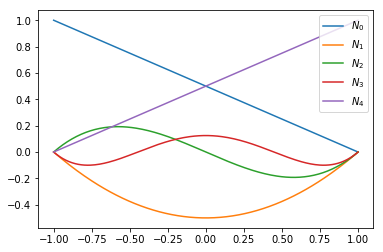

In [84]:
n = 4
N = Lobatto(n)
x = np.linspace(-1,1,200)
plt.figure()
for i in range(n+1):
    plt.plot(x,N[i](x),label='$N_{}$'.format(i))
plt.legend()
plt.show()
    

><div class="alert alert-block alert-info">
What is the difference between the three shape functions associated to Lobatto at order 2 and the one of quadratic nodal elements. Explain why Lobatto polynomials are called hierarchical.


The function to create elementary matrices is as follows

In [85]:
def Elementary_matrices(order, h):
    N = Lobatto(order)
    K_elem = np.zeros((order+1, order+1))
    M_elem = np.zeros((order+1, order+1))
    for ii in range(order+1):
        for jj in range(order+1):
            temp = np.polyint(N[ii]*N[jj])
            M_elem[ii, jj] = temp(1)-temp(-1)
            temp = np.polyint(np.polyder(N[ii])*np.polyder(N[jj]))
            K_elem[ii, jj] = temp(1)-temp(-1)
    M_elem = (h/2/c_0**2)*M_elem
    K_elem = (2/h)*K_elem
    return M_elem, K_elem

><div class="alert alert-block alert-info">
In this function, the integration is done analytcally. You can modify it to use a numerical integration as presented in the other tutorial


We can define an error function that compute, for a given mode, the error between the numerical and analytical values

In [86]:
def compute_error(n,order,n_mode):
    delta = L/n
    M_e,K_e = Elementary_matrices(order, delta)
    nb_dof=(n+1)+n*(order-1)
    K =np.zeros((nb_dof,nb_dof))
    M =np.zeros((nb_dof,nb_dof))
    for ie in range(n): # loop on the elements
        dof = slice(order*ie, order*ie+order+1) # indices of the local dofs
        K[dof,dof] += K_e
        M[dof,dof] += M_e
    omega = np.sort(np.sqrt(eigs(K, n_mode, M,which='SM',return_eigenvectors=False)))
    error = np.absolute(omega[-1]-n_mode+1) 
    return error


In [87]:
n = 4
order = 2
compute_error(10,4,3)

9.463980710222586e-10

><div class="alert alert-block alert-info">
By using the following script. What can you say about the order of convergence of
order elements. You can test on modes 3 and 7 for instance. What can we say, for higher modes, in the zone associated to coarse meshes ?

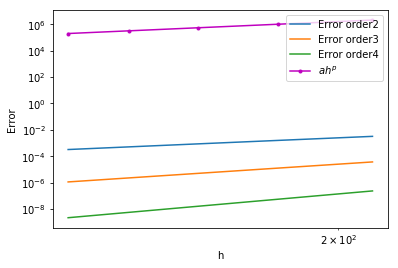

In [88]:
n_max = 10
h=np.zeros(n_max)
current_mode = 3
tab_order=[2,3,4]
eps=np.zeros((len(tab_order),n_max))
for i_order in range(len(tab_order)): 
    for i_n in range(5,n_max):
        h[i_n] = L/i_n 
        eps[i_order,i_n]=compute_error(i_n,tab_order[i_order],current_mode)
plt.figure()
for i_order in range(len(tab_order)):
    plt.loglog(h,eps[i_order,:],label='Error order{}'.format(tab_order[i_order]))
a = 1e-3
p=4 
plt.loglog(h,a*h**p,'m.-',label='$ah^p$') 
plt.xlabel('h') ; 
plt.ylabel('Error') 
plt.legend()
plt.show()